In [1]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist
from numpy.linalg import LinAlgError
import re

from sklearn.preprocessing import StandardScaler

2024-09-06 10:31:01.471883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 10:31:01.588237: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-06 10:31:01.590975: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-06 10:31:01.590992: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Read in data

In [6]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [ ]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [7]:
# Format the data to work with existing code
labels = node_labels

# just look at first (whatever is specified) timepoint
dense_adj = As[0]

Define functions for notebook

In [2]:
def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below


# def plot_ellipse(ax, mean, cov, color):
#     eigenvalues, eigenvectors = np.linalg.eigh(cov)
#     order = eigenvalues.argsort()[::-1]
#     eigenvalues = eigenvalues[order]
#     eigenvectors = eigenvectors[:, order]
#     angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
#     width, height = 2 * np.sqrt(eigenvalues[:2])
#     ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
#     ax.add_patch(ellipse)


def plot_ellipse(ax, mean, cov, color, lw=2):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=color, facecolor='none', lw=lw, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)



# TO AVOID SINGULAR MATRIX ERROR
def points_within_ellipse(points, mean, cov, regularization=1e-32):
    try:
        # Attempt to calculate the inverse of the covariance matrix
        inv_cov = np.linalg.inv(cov)
    except LinAlgError:
        # If the matrix is singular, regularize and retry
        cov += np.eye(cov.shape[0]) * regularization
        inv_cov = np.linalg.inv(cov)
    
    # Calculate the Mahalanobis distance from the mean
    diff = points - mean
    mahalanobis_distances = np.sum(diff @ inv_cov * diff, axis=1)
    
    # Points within the ellipse have a Mahalanobis distance <= 1
    return mahalanobis_distances <= 1


In [8]:
k = 4
d = 12

100%|██████████| 10/10 [00:00<00:00, 29.58it/s]
/tmp/ipykernel_34915/4181507203.py:60: RuntimeWarning: invalid value encountered in sqrt
  volume_or_area = np.sqrt(det_cov)


100%|██████████| 25/25 [00:01<00:00, 13.07it/s]
/tmp/ipykernel_34915/4181507203.py:60: RuntimeWarning: invalid value encountered in sqrt
  volume_or_area = np.sqrt(det_cov)


100%|██████████| 30/30 [00:02<00:00, 12.95it/s]
/tmp/ipykernel_34915/4181507203.py:60: RuntimeWarning: invalid value encountered in sqrt
  volume_or_area = np.sqrt(det_cov)


100%|██████████| 40/40 [00:03<00:00, 12.94it/s]
/tmp/ipykernel_34915/4181507203.py:60: RuntimeWarning: invalid value encountered in sqrt
  volume_or_area = np.sqrt(det_cov)


100%|██████████| 45/45 [00:03<00:00, 14.50it/s]
/tmp/ipykernel_34915/4181507203.py:60: RuntimeWarning: invalid value encountered in sqrt
  volume_or_area = np.sqrt(det_cov)


100%|██████████| 50/50 [00:04<00:00, 11.60it/s]


/tmp/ipykernel_34915/4181507203.py:60: RuntimeWarning: invalid value encountered in sqrt
  volume_or_area = np.sqrt(det_cov)


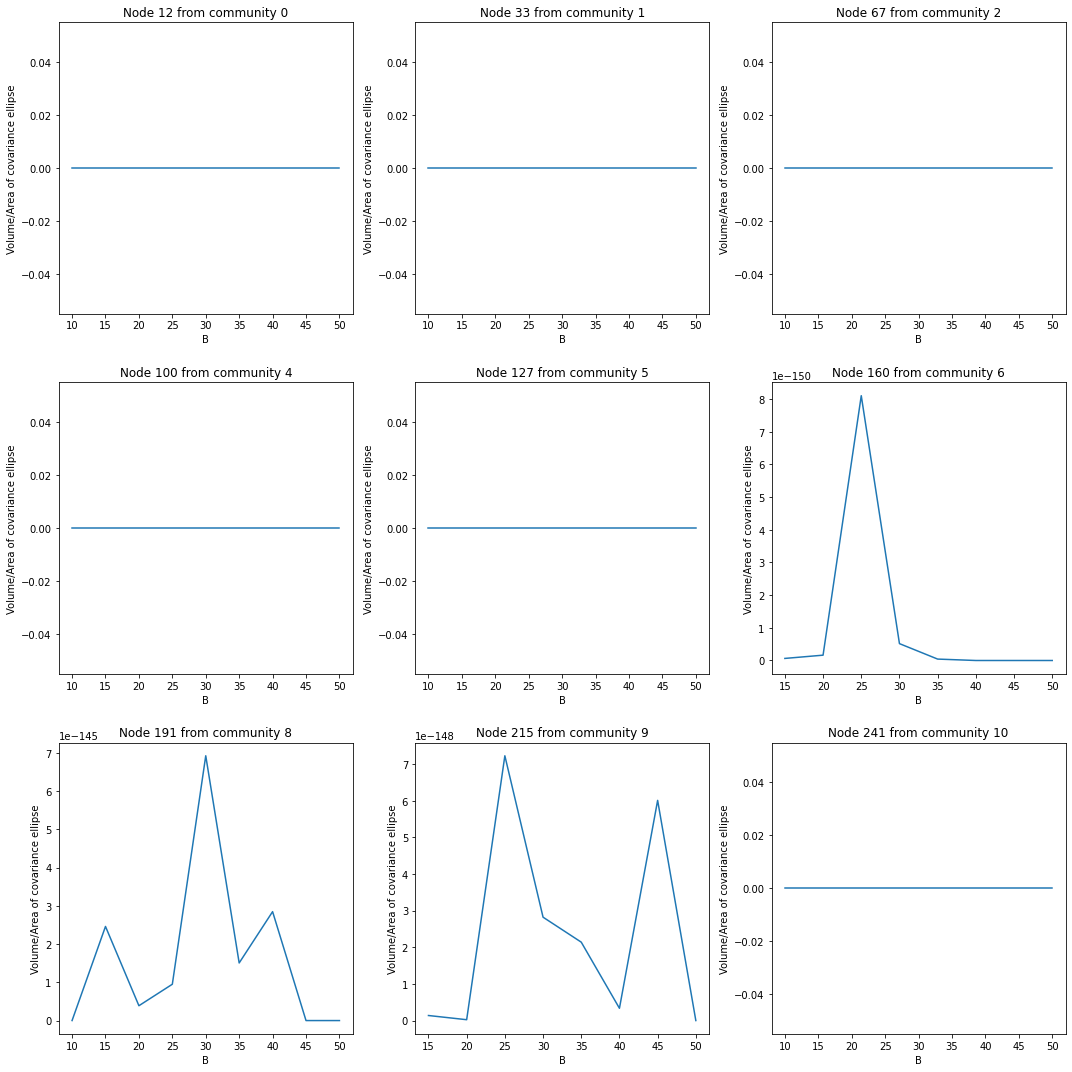

In [23]:
B_values = range(10, 51, 5)  # Example B values

# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

volume_or_area_array = np.zeros((n, len(B_values)))

# Iterate over B values with an index
for idx, B in enumerate(B_values):

    A_boots_list = []
    volume_or_area_list = []

    for b in tqdm(range(B)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)
    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # Standardize the data in the Dimension_1 and Dimension_2 columns
    # standardize the data for the obs and the B bootstraps for each B value
    scaler = StandardScaler()
    yadf[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(yadf[["Dimension_1", "Dimension_2"]])

    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, B + 1)


    # for each node, calculate the mean and covariance using the bootstraps and the 1obs
    for i in range(n):
        # Filter data for node number and select the relevant dimensions
        node_number = i
        data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

        # Calculate the mean and covariance considering all d dimensions
        mean_d_dim = np.mean(data_d_dim, axis=0)
        cov_d_dim = np.cov(data_d_dim, rowvar=False)

        # Compute the determinant of the covariance matrix
        det_cov = np.linalg.det(cov_d_dim)

        # Ensure determinant is non-negative
        if det_cov >= 0:
            volume_or_area = np.sqrt(det_cov)
        else:
            # Handle the case of negative determinant
            volume_or_area = np.nan  # Or set to 0, raise an error, or handle as needed
            print(f"Warning: Negative determinant encountered for node {j}, setting volume/area to NaN.")


        # If you want a more interpretable scalar (the volume or area), take the square root of the determinant
        volume_or_area = np.sqrt(det_cov)
        volume_or_area_list.append(volume_or_area)

    volume_or_area_array[:, idx] = volume_or_area_list



    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # plot column j of volume_or_area_array 
    j_list = [12,33,67,100,127,160,191,215,241]
    j = j_list[idx]
    ax.plot(B_values, volume_or_area_array[j, :], label=f'Node {j}')
    ax.title.set_text(f'Node {j} from community {yadf["tau"][j]}')
    ax.set_xlabel('B')
    ax.set_ylabel('Volume/Area of covariance ellipse')

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.savefig('volume_area_plot.png') 

# Show the combined plot
plt.show()
